# LSTM Time-Series Forecasting for SPY 
**Project:** Time-series forecasting for equities using LSTM

**Author:** Khalid Hajeer

**Last updated:** September 1, 2025

## Table of Contents
1. [Introduction](#1-introduction)
2. [Setup & Reproducibility](#2-setup--reproducibility)  
3. [Data Collection & Preprocessing](#3-data-collection--preprocessing)  
4. [Exploratory Data Analysis (EDA)](#4-exploratory-data-analysis-eda)  
5. [Feature Engineering](#5-feature-engineering)
6. [Systematic Feature Selection](#6-systematic-feature-selection)  
7. [Baselines](#7-baselines)  
8. [LSTM Data Preparation & Architecture](#8-lstm-data-preparation--architecture)  
9. [Training & Validation](#9-training--validation) 
10. [Test Evaluation & Backtest](#10-test-evaluation--backtest)
11. [Conclusion](#11-conclusion)
12. [Appendex](#12-Appendex)


## 1. Introduction

The **SPDR S&P 500 ETF Trust (SPY)** tracks the performance of the S&P500 index - a benchmark of 500 leading publicly listed companies in the United States. SPY is highly liquid and often used as a proxy for the overall U.S. stock market.

> **Note:** Long run performance figures vary by window and methodology. In this project, SPY serves primarily as a liquid benchmark for modelling and backtesting rather than as a statement about historical returns.

Finance time-series forecasting is challenging: signals are weak, noisy, and non-stationary. Patterns can emerge, decay, or invert with regime shifts and market feedback. We therefore use strict chronological splits, early stopping on validation correlation, refitting before test, and cost-aware backtesting to assess whether any learned structure is robust.

### Objectives
Build and evaluate a **Long Short-Term Memory (LSTM)** network (a type of Recurrent Neural Network (RNN)) to predict the **next day return** of SPY. We model **log returns** instead of raw prices for better stationarity and comparability across time.
$$
r_t = \ln \left(\frac{C_t}{C_{t-1}}\right) = \ln C_t - \ln C_{t-1}.
$$
where:
- $r_t$ is the log return at day $t$
- $C_t$ is close at day $t$
- $C_{t-1}$ is close at day $t-1$

From a predicted log return $\hat{r}_{t+1}$, we recover the next day close:
$$
\hat{C}_{t+1} = C_t \cdot e^{\hat{r}_{t+1}}
$$

### Methodology Overview

**Setup & Reproducibility**  
    Import libraries; set deterministic seeds; define a central config (paths, splits, dates, costs).

**Data Collection & Preprocessing**  
    Pull daily OHLCV (Open, High, Low, Close, Volume) from Alpaca; validate monotonic timestamps; enforce dtypes; handle missing values; verify no lookahead in any merge; persist a clean, versioned dataset.

**Exploratory Data Analysis (EDA)**  
    Plot distributions and volatility; examine regime hints; inspect missingness and outliers.

**Feature Engineering**   
    Build lagged/rolling features (momentum, volatility, volume, statistical); shift all predictors to t-1 to avoid lookahead; persist a versioned feature catalog.

**Systematic Feature Selection**   
    Rank features on train only; freeze the selected set for modelling.

**Baselines**  
    Train Ridge and XGBoost baselines plus a naïve persistence/momentum rule; evaluate with identical splits and metrics (Pearson correlation, MSE, and trading PnL metrics).

**LSTM Data Preparation & Architecture**   
    Fit scalers on train only; create a sliding window sequence; specify LSTM layers, units, dropout with fixed seeds; checkpoint models; ensure target alignment.

**Training, Validation & Model Selection**  
    Train with early stop on validation Pearson correlation; record the best epoch along with its weights and metrics. The best epoch is then used to refit the model from scratch on combined train+val set (without early_stopping), after which test predictions are generated and all artefacts are archived.

**Backtest & Test Evaluation**  
    Map signal -> position; compare against baselines and a label-shuffle control; report Sharpe, MaxDD, Turnover; plot a $1k wealth chart for the test set.

**Diagnostics**  
    Inspect rolling correlation/Sharpe, error-by-volatility profiles, and residual ACF; review feature usage/coverage and data leakage checks.

**Conclusions**  
    Summarise findings; discuss limitations; suggest next steps.

### Why LSTM?
LSTMs capture patterns in sequential and temporal data by learning which parts of past information are most relevant for future predictions. They are a type of Recurring Neural Network (RNN) designed to overcome the vanishing gradient problem, where gradients become extremely small during backpropagation through time, making it difficult for standard RNNs to learn long-term dependencies.
By incorporating gating mechanisms, LSTMs can retain important information over longer sequences, making them particularly suited for stock market time-series forecasting.

### Scope & Assumptions
- The approach generalises to any Alpaca-supported ticker; performance will vary by asset, liquidity, and regime.
- Corporate actions (splits/dividends) and survivorship biases must be handled explicitly.
- Inputs are historical OHLCV + engineered features only (no macro/news)
- All transformations are fit on training data only and applied forward to avoid leakage.

### Expected Output
- A trained LSTM model that predicts next-day log returns.
- A test-only backtest report with after-cost metrics, $1k wealth chart, baselines, and a shuffle control.
- Visual comparisons: predicted vs. realised returns (and derived prices).
- One-step-ahead forecast for the next trading day
- A concise tearsheet and a longer Methods PDF

### Financial Disclaimer
This project is for **educational purposes only** and is **not financial advice**.
Model outputs are uncertain and should not be used for live trading without independent verification and risk controls.

> "If you were to give a monkey a typewriter and let him randomly hit keys forever, then he would eventually type Shakespeare's Hamlet - word for word."

## 2. Libraries

In [ ]:
# Core libraries 
import os, sys, random
import numpy as np
import pandas as pd
from dotenv import load_dotenv
from datetime import datetime
import json
from pathlib import Path

# Machine learning libraries
import tensorflow as tf
from tensorflow import keras
print(tf.config.list_physical_devices('GPU'))
print(f"TensorFlow has access to the following devices:\n{tf.config.list_physical_devices()}")
print(f"TensorFlow version: {tf.__version__}")

from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance
from sklearn.metrics import make_scorer, mean_squared_error

# Visualization libraries
import matplotlib.pyplot as plt

# Project modules
# Add parent directory (so Python can see src/)
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")))
# TODO: Update requirements.txt at the end
from src.data import get_stock_data, align_calendar
from src.features import make_targets, build_feature_matrix
from src.validate import run_all_validations
from src.metrics import *
from src.backtest import single_asset_backtest
from src.models.baseline import *
from src.utils import align_X_y

# Set seed for reproducibility
GLOBAL_SEED = 42
random.seed(GLOBAL_SEED)
np.random.seed(GLOBAL_SEED)
tf.random.set_seed(GLOBAL_SEED)

pd.options.display.float_format = "{:.6f}".format
print("Imports ready!")

[]
TensorFlow has access to the following devices:
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]
TensorFlow version: 2.16.2
Imports ready!
PID A: 35628


## 3. Data Collection & Preprocessing

First, let's fetch the data we'll be working with.

We'll use the Alpaca API credentials from the environment and fetch 10 years of daily OHLCV (+ VWAP, trade_count) data for SPY.

To save time on future runs, the dataet is cached locally at 'data/raw/SPY.parquet'.
If the cache is missing or we set 'FORCE_REFRESH=True', the data will be pulled fresh from Alpaca and saved to that path.

After fetching, we make the data is clean and ready:
- enforce a UTC 'DatetimeIndex' that is monotonic and unique,
- coerce numeric dtypes, and remove duplicates/missing values,

Finally, we align the dataset with the trading calendar, ensuring no gaps remain before downstream feature engineering and backtesting.

In [2]:
# Load API credentials from .env file (ALPACA_API_KEY, ALPACA_SECRET_KEY)
load_dotenv()

symbol = "SPY"
CACHE_PATH = "../data/raw/SPY.parquet" # local cache location
FORCE_REFRESH = True # set to True to fetch fresh data

# Fetch data from Alpaca if needed, else load from cache
# Output is a Pandas DataFrame with UTC DatetimeIndex
df = get_stock_data(
    symbol=symbol,
    years=10,
    path=CACHE_PATH,
    force_refresh=FORCE_REFRESH,
    feed="iex"
)

# Align calendar: ensuring  sorted, unique UTC DatetimeIndex
df = align_calendar(df)

## 4. Exploratory Data Analysis (EDA)

Before feature engineering, let's explore the dataset and get a sense of what we're working with.

We'll start with a quick tabulat overview:
- look at the first few rows to see the raw structure,
- check datatypes and missing values,
- review summary statistics like mean, std, and ranges

After that, we'll plot the closing price and trading value over time to spot trends, volatility clusters, and any unusual behaviour.

In [3]:
# Display the first 5 rows
print("Head of DataFrame:")
display(df.head())

# Concise summary: dtypes, non-null counts, memory usage
print("\n DataFrame Info:")
df.info()

# Descriptive statistics: mean, std, min, max, percentiles
print("\n DataFrame Descriptive Statistics:")
display(df.describe())

Head of DataFrame:


,open,high,low,close,volume,vwap,trade_count
timestamp,,,,,,,
2018-11-01 04:00:00+00:00,271.600000,271.600000,271.600000,271.600000,200.000000,271.600000,1.000000
2020-07-27 04:00:00+00:00,321.625000,323.390000,320.820000,323.260000,647693.000000,322.484750,4768.000000
2020-07-28 04:00:00+00:00,322.570000,323.635000,320.850000,321.240000,521475.000000,322.427003,4238.000000
2020-07-29 04:00:00+00:00,322.120000,325.705000,322.120000,325.160000,600377.000000,324.227394,4808.000000
2020-07-30 04:00:00+00:00,321.710000,324.385000,319.640000,323.960000,612074.000000,322.353494,4800.000000



 DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1285 entries, 2018-11-01 04:00:00+00:00 to 2025-09-04 04:00:00+00:00
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   open         1285 non-null   float64
 1   high         1285 non-null   float64
 2   low          1285 non-null   float64
 3   close        1285 non-null   float64
 4   volume       1285 non-null   float64
 5   vwap         1285 non-null   float64
 6   trade_count  1285 non-null   float64
dtypes: float64(7)
memory usage: 112.6 KB

 DataFrame Descriptive Statistics:


,open,high,low,close,volume,vwap,trade_count
count,1285.000000,1285.000000,1285.000000,1285.000000,1285.000000,1285.000000,1285.000000
mean,460.581444,463.125751,457.833467,460.672549,1197874.210895,460.575700,10698.400000
std,81.218350,81.261353,81.085154,81.228733,583780.442712,81.184738,4091.642318
min,271.600000,271.600000,271.600000,271.600000,200.000000,271.600000,1.000000
25%,399.510000,402.290000,395.740000,398.905000,802416.000000,398.853951,7976.000000
50%,439.800000,441.990000,437.685000,439.690000,1071259.000000,440.129378,10194.000000
75%,523.490000,525.860000,519.770000,523.080000,1443159.000000,523.390843,12908.000000
max,647.455000,649.470000,645.365000,649.020000,4791892.000000,648.057250,32133.000000


PID B: 35628
X in globals? True


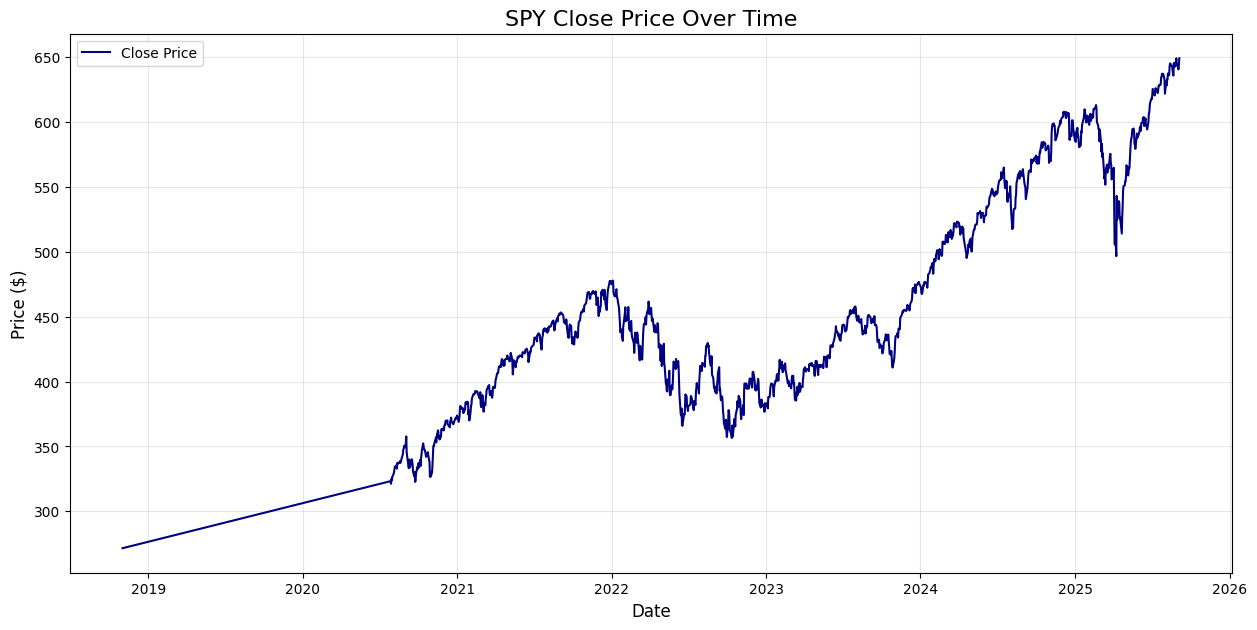

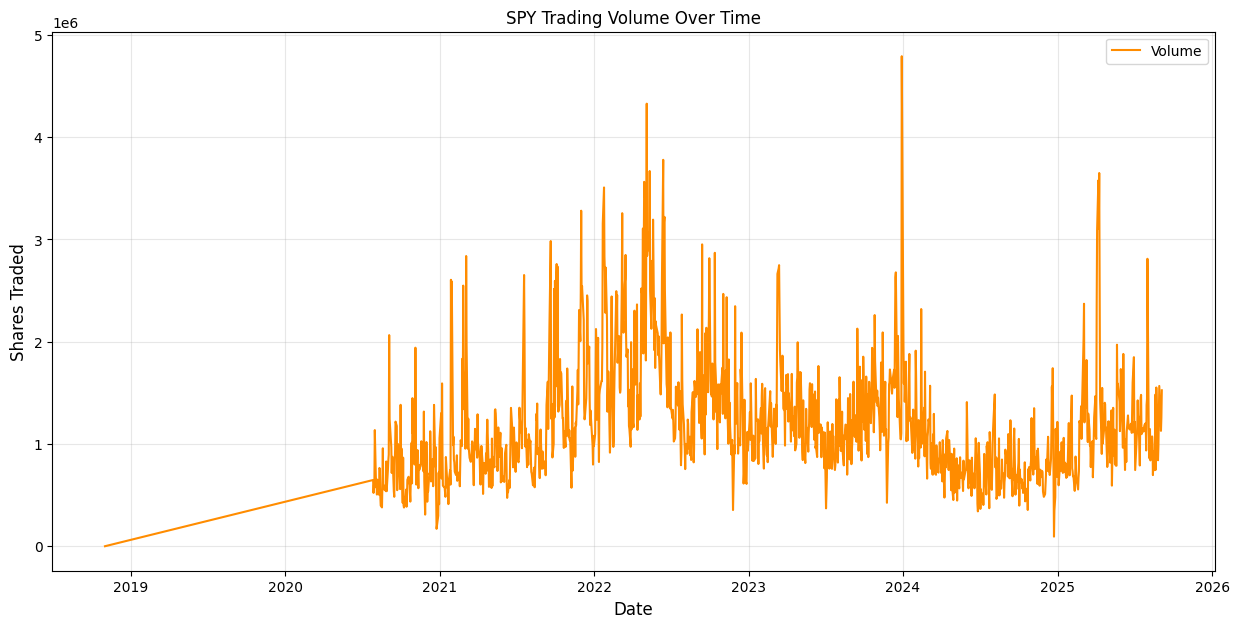

In [ ]:
# Plot the close price over time
plt.figure(figsize=(15, 7))
plt.plot(df.index, df['close'], label='Close Price', color='navy')
plt.title('SPY Close Price Over Time', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Price ($)', fontsize=12)
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Plot the volume over time
plt.figure(figsize=(15, 7))
plt.plot(df.index, df['volume'], label='Volume', color='darkorange')
plt.title('SPY Trading Volume Over Time')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Shares Traded', fontsize=12)
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

## 5. Feature Engineering

Now let's build the targets and the feature matrix using our module functions.

**Why returns (not prices)?**
Returns are closer to stationary and live on a comparable scale across time.
We'll predict next day log returns and also keep a volatility-normalised target for diagnostics.

**What we'll do here**
1) Create targets ('y_raw', 'y_vol') from close prices.
2) Build a lag-safe feature matrix from our raw data (including price, technical, volume, volatility, and statistical blocks) via 'build_feature_matrix'.
3) Run validation checks to guard against common issues (index, NaNs/inf, and obvious lookahead leakage) 
4) Quick preview + visuals

All transforms use past-only information and apply a central lag so that features at timet $t$ predict $t-1$.

In [5]:
# 1) Targets from close prices
targets = make_targets(df["close"], vol_span=20) # -> columns: log_return, ewma_vol_20, y_raw, y_vol

# 2) Feature matrix (lag-safe; applies a central lag so X_t predicts y_{t+1})
feature_matrix = build_feature_matrix(df, lag_days=1, drop_na_rows=True)

# 3) Validations (index, NaNs/inf, basic anti-leakage structure)
run_all_validations(
    raw=df,
    X=feature_matrix,
    y=targets["y_raw"].reindex(feature_matrix.index), # align to X
    required_raw_cols=("open","high","low","close"),
    expected_central_lag_days=1
)

# 4) Keep a working frame for quick inspection
features = feature_matrix.join(targets[["y_raw", "y_vol"]], how="inner")
display = (features.head(10))
print(f"\nFeature shape: {feature_matrix.shape}, with {feature_matrix.columns.nunique()} columns")

TypeError: Index(...) must be called with a collection of some kind, 'close' was passed

### 5.1 What's inside the matrix?

- **Price-based:** spreads (high-low, close-ipen), ratios (close/open), simple & log returns, short-horizon momentum.
- **Technical:** SMA, EMA, RSI(14), MACD(line + signal + histogram), Bollinger Bands (lower, middle, upper).
-  **Volatility & Rolling Stats:** rolling $\sigma$ of returns, rolling mean/std, z-scores.
- **Volume-based:** $\Delta$ volume, volume/avg, OBV, VWAP deviations, trade count stats.
- **Statistical:** Shannon entropy (windows), Hurst exponent (long memory), rolling autocorrelations.

All columns are shifted to $t-1$ within the orchestrator so there's no lookahead.

In [ ]:
print("feature matrix info:")
feature_matrix.info()

print("\nNaN counts (should be 0 after drop_na_rows=true):")
display(feature_matrix.isna().sum().sort_values(ascending=False).head(10))

print("\nTargets preview:")
display(targets[["y_raw", "y_vol"]].reindex(feature_matrix.index).describe())

### 5.2 Quick Visuals

A couple of lightweight checks help spot obvious issues before modelling:
- **Indicator subplots** on a recent slice (e.g., last 500 days)
- **Correlation heatmap** (high-level view to spot multicollinearity clusters).

In [ ]:
# Indicator subplots

# using last 500 days (to keep plot readable)
df_plot = features.tail(500).copy()

fig, (ax1,  ax2, ax3) = plt.subplots(3, 1, figsize=(15,12), sharex=True)

# Price
ax1.plot(df_plot.index, feature_matrix.loc[df_plot.index, 'close'], label='Close Price', color='navy')
ax1.set_title("Price with MACD & RSI (last 500 days)")
ax1.set_ylabel("Price ($)")
ax1.legend()
ax1.grid(True, alpha=0.3)

# MACD
ax2.plot(df_plot.index, feature_matrix.loc[df_plot.index, "macd"], label="MACD", color='green')
ax2.set_ylabel("MACD")
ax2.legend()
ax2.grid(True, alpha=0.3)

# RSI
ax3.plot(df_plot.index, feature_matrix.loc[df_plot.index, "rsi_14"], label="RSI (14)", color='darkgreen')
ax3.axhline(70, color='red', linestyle='--', alpha=0.5, label='Overbought (70)')
ax3.axhline(30, color='red', linestyle='--', alpha=0.5, label='Oversold (30)')
ax3.set_ylabel("RSI")
ax3.set_xlabel("Date")
ax3.legend()
ax3.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [ ]:
# Correlation heatmap
FAMILIES = [
    "sma_", "ema_", "rsi_", "macd", "bb_",  # technicals
    "momentum", "simple_return", "log_return",            # price-derived
    "vol_", "rolling_std_", "rolling_mean_", "z_score_",  # volatility/stats
    "obv", "volume_", "volume_over_avg", "trade_count",   # volume
    "entropy", "hurst", "autocorr"                        # statistical
]
cols_to_show = [c for c in feature_matrix.columns if any(prefix in c for prefix in FAMILIES)][:25]

correlation = feature_matrix[cols_to_show].corr().to_numpy()
fig = plt.figure(figsize=(10, 8))
im = plt.imshow(correlation, cmap='coolwarm', vmin=-1, vmax=1)
plt.colorbar(im, fraction=0.046, pad=0.04)
plt.title("Feature Correlation Heatmap (subset)")
plt.xticks(range(len(cols_to_show)), cols_to_show, rotation=90)
plt.yticks(range(len(cols_to_show)), cols_to_show)
plt.tight_layout()
plt.show()  

## 6. Systematic Feature Selection
We've engineered ~40+ features; some help, some don't. Feeding all of them into our LSTM can mask the real patterns, slow training , and hurt generalisation. Instead, we'll rank features on the training window only and freeze a compact set for modelling.

**What we'll do**
1) Define train/val/test** splits (chronological).
2) Fit a Random Forest Regressor on train only.
3) Compute permutation importance on the validation window (model-agnostic reduces Random Forest bias).
4) Pick the top-N features and optionally deduplicate highly correlated ones.
5) Freeze the selected feature list for downstream models.

In [ ]:
# y from targets, aligned to feature_matrix index
y = targets["y_raw"].reindex(feature_matrix.index)

# Keep numeric features only; clean infs; align & drop NaNs
X = (
    feature_matrix
    .select_dtypes(include=[np.number])
    .replace([np.inf, -np.inf], np.nan)
)
X, y = align_X_y(X, y, dropna=True)

# Chronological split: Train / Val / Test (70, 15, 15)
n = len(X)
i_train = int(n * 0.70)
i_val = int(n * 0.85)

X_train, y_train = X.iloc[:i_train], y.iloc[:i_train]
X_val, y_val = X.iloca[i_train:i_val], y.iloc[i_train:i_val]
X_test, y_test = X.iloc[i_val:], y.iloc[i_val:]

print(f"Shapes - Train: {X_train.shape}, Val: {X_val.shape}, Test: {X_test.shape}")

# Fit RF on Train ONLY
rf = RandomForestRegressor(
    n_estimators=600,
    max_depth=None,
    min_samples_leaf=2,
    n_jobs=-1,
    random_state=42
).fit(X_train, y_train)

# Permutation importance on VALIDATION, scored by Pearson correlation
r_scorer = make_scorer(pearson_corr, greater_is_better=True)

perm = permutation_importance(
    rf, X_val, y_val,
    n_repeats=20,
    random_state=42,
    scoring=r_scorer
)

imp_df = (
    pd.DataFrame({
        "feature": X_val.columns,
        "importance_mean": perm.importances_mean,
        "importance_std": perm.importances_std
    })
    .sort_values("importance_mean", ascending=False)
    .reset_index(drop=True)
)

# Select top-N and prune near-duplicates
N = 20
top_n_features = imp_df["feature"].tolist()

def prune_redundant(features, Xref, corr_threshold=0.95):
    kept = []
    for feature in features:
        if not kept:
            kept.append(feature); continue
        if all (abs(Xref[feature].corr(Xref[k])) < corr_threshold for k in kept):
            kept.append(feature)
        return kept
    
SELECTED_FEATURES = prune_redundant(top_n_features, X_train, corr_threshold=0.95)
print(f"\nTop {N} by permutation importance:\n {top_n_features}")
print(f"\nAfter redundancy pruning ({len(SELECTED_FEATURES)} kept):\n{SELECTED_FEATURES}")

# Freeze to join JSON for reproducability
ARTIFACTS_DIR = Path("artifacts"); ARTIFACTS_DIR.mkdir(parents=True, exist_ok=True)
FEATURE_SET_PATH = ARTIFACTS_DIR / "feature_set.json"

payload = {
    "selected_features": SELECTED_FEATURES,
    "meta": {
        "model": "RandomForestRegressor",
        "n_estimators": 600,
        "scoring": "pearson_r",
        "n_repeats": 20,
        "prune_threshold": 0.95,
        "train_range": [str(X_train.index.min()), str(X_train.index.max())],
        "val_range":   [str(X_val.index.min()),   str(X_val.index.max())],
        "random_state": 42,
    },
}
FEATURE_SET_PATH.write_text(json.dumps(payload, indent=2))
print(f"\nSaved frozen feature set → {FEATURE_SET_PATH}")

## §7. Baselines

Before we build the LSTM, let's set simple, transparent baselines to sanity check signal quality and avoid overfitting. These serve as benchmarks that any more sophisticated model should surpass.

What we evaluate
- **Persistence ($r_t -> r_{t+1}$)**: predicts the next day's return from the previous day's return.
- **Ridge Regression (tabular)**: linear model on the frozen feature set from §6. The regularisation parameter $\alpha$ is chosen using validation Pearson correlation (RMSE used as a tiebreaker).
- **XGBoost (tabular)**: tree-based model with early stopping on validation RMSE; we report the best number of trees.

Models are trained on the training split and tuned on the validation split, using Pearson correlation as the primary selection metric and RMSE as a secondary tiebreaker. Validation and test results are reported seperately, with no peeking into the test set.

> *Why Correlation?* Pearson correlation is scale-free and reflects directional/relative accuracy for daily returns. 

In [ ]:
# Compute baseline predictions

# Persistence uses the next-day-aligned target series; at time t ir predicts r_t for r_{t+1}
persistence_pred_val_series = predict_persistence(y_val)
persistence_pred_test_series = predict_persistence(y_test)

# Ridge: fit on Train, select alpha on validation correlation; refit on Train+Val for test
ridge_model, ridge_diagnostics, ridge_val_pred_series = train_ridge_with_val(
    X_train=X_train,
    y_train=y_train,
    X_val=X_val,
    y_val=y_val,
    alphas=tuple(np.logspace(-4, 4, 25)),
    refit_on_train_val=True
)
ridge_test_pred_series = predict_series(ridge_model, X_test, name="ridge_pred_test")

# XGBoost: early stopping on validation; refit on train+val (best_n) for test
xgb_model, xgb_diagnostics, xgb_val_pred_series = train_xgb_with_val(
    X_train=X_train,
    y_train=y_train,
    X_val=X_val,
    y_val=y_val,
    n_estimators=2000,
    learning_rate=0.05,
    max_depth=3,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_lambda=1.0,
    min_child_weight=1.0,
    early_stopping_rounds=50,
    n_jobs=-1,
    random_state=42,
    refit_on_train_val=True
)
xgb_test_pred_series = predict_series(xgb_model, X_test, name="xgb_pred_test")

#TODO: MOVE ALL FUNCTIONS TO MODULESA
# Scoring helpers
def score_prediction(true_returns_series: pd.Series, predicted_returns_series:pd.Series):
    """    Score predictions using the project's alignment/cleaning: returns (pearson_r, rmse, directional_accuracy_percent)."""
    # Wrap predictions as a single-column DataFrame
    predicted_df = pd.DataFrame({"predicted": pd.Series(predicted_returns_series)})

    # Align and drop NaNs (post-lag edges, infs handled upstream)
    X_aligned, y_aligned = align_X_y(predicted_df, pd.Series(true_returns_series), dropna=True)

    predicted_aligned_series = X_aligned["predicted"].astype("float64")
    y_aligned_series = y_aligned.astype("float64")

    correlation = pearson_corr(y_aligned_series, predicted_aligned_series)
    rmse_value = float(np.sqrt(mean_squared_error(y_aligned_series, predicted_aligned_series)))
    directional_accuracy = float((np.sign(y_aligned_series) == np.sign(predicted_aligned_series)).mean() * 100.0)

    return correlation, rmse_value, directional_accuracy

# Assemble metrics table
metrics_rows = [
    ["Persistence", 
     *score_prediction(y_val, persistence_pred_val_series),
     *score_prediction(y_test, persistence_pred_test_series)
    ],
    [f"Ridge (alpha={ridge_diagnostics['best_alpha']:.3g})", 
     *score_prediction(y_val, ridge_val_pred_series),
     *score_prediction(y_test, ridge_test_pred_series)
    ],
    [f"XGBoost (n={xgb_diagnostics['best_n_estimators']})", 
     *score_prediction(y_val, xgb_val_pred_series),
     *score_prediction(y_test, xgb_test_pred_series)
    ]
]

baseline_metrics_df = pd.DataFrame(
    metrics_rows,
    columns=[
        "Model",
        "Val Pearson corr", "Val RMSE", "Val Directional Accuracy %",
        "Test Pearson corr", "Test RMSE", "Test Directional Accuracy %"
    ]
).set_index("Model")

display(
    baseline_metrics_df.style.format({
        "Val Pearson corr": "{:.3f}", "Test Pearson corr": "{:.3f}",
        "Val RMSE": "{:.3f}", "Test RMSE": "{:.3f}",
        "Val Directional Accuracy %": "{:.2f}", "Test Directional Accuracy %": "{:.2f}",
    }).set_caption("§7 Baseline Metrics")
)

# inspect chosen hyperparameters at a glance
ridge_diagnostics, xgb_diagnostics

## 8. LSTM Data Preperation & Architecture

We need to turn the frozen feature set into sequences an LSTM can learn from. We'll keep things simple: use the selected colummns, split by time, standardise from the train slice only, window into '(samples, timesteps, features'), and then define a compact LSTM.

In [ ]:
# Load frozen feature list (fallback to all features if not found)
FEATURE_SET_PATH = Path("artifacts/feature_set.json")
if FEATURE_SET_PATH.exists():
    SELECTED_FEATURES = json.loads(FEATURE_SET_PATH.read_text())["selected_features"]
else:
    SELECTED_FEATURES = feature_matrix.columns.tolist()
    print("Frozen feature set not found; using all features.")

# Keep selected numeric features
cols = [col for col in SELECTED_FEATURES if col in feature_matrix.columns]
X_full = feature_matrix[cols].select_dtypes(include=[np.number]).copy()

# Target: next-day log return aligned to X
y_full = targets["y_raw"].reindex(X_full.index).astype("float64")

# Align and drop NaNs (post-lag edges, infs handled upstream)
X_full, y_full = align_X_y(X_full, y_full, dropna=True)

# Chronological split (70/15/15)
n = len(X_full)
i_train = int(n * 0.70)
i_val = int(n * 0.85)

X_train, y_train = X_full.iloc[:i_train], y_full.iloc[:i_train]
X_val, y_val = X_full.iloc[i_train:i_val], y_full.iloc[i_train:i_val]
X_test, y_test = X_full.iloc[i_val:], y_full.iloc[i_val:]

def _span(idx):
    return f"{idx[0].date()} -> {idx[-1].date()} (n={len(idx)})"

print(f"\nDataframe split sizes:")
print(f"Training: {X_train.shape} {_span(X_train.index)}")
print(f"Validation: {X_val.shape} {_span(X_val.index)}")
print(f"Test: {X_test.shape} {_span(X_test.index)}")

In [ ]:
# Apply Standard Scaler to data

x_scaler = StandardScaler()
y_scaler = StandardScaler()

x_scaler.fit(X_train)
y_scaler.fit(y_train.to_frame())

X_train_scaler = x_scaler.transform(X_train)
X_val_scaler = x_scaler.transform(X_val)
X_test_scaler = x_scaler.transform(X_test)

y_train_scaler = y_scaler.transform(y_train.to_frame())
y_val_scaler = y_scaler.transform(y_val.to_frame())
y_test_scaler = y_scaler.transform(y_test.to_frame())


In [ ]:
sequence_length = 60 

def make_sequence(X2d: np.ndarray, y2d: np.ndarray, sequence_length: int):
    """Transforms time series data into overlapping sequences for LSTM input."""
    n = len(X2d)
    if n <= sequence_length:
        raise ValueError(f"Not enough rows ({n}) for sequence length {sequence_length}.")
    Xs = np.stack([X2d[i:i+sequence_length, :] for i in range(n - sequence_length)])
    ys = np.stack([y2d[i+sequence_length-1, :] for i in range(n - sequence_length)])
    return Xs.astype("float32"), ys.astype("float32")

X_train, y_train = make_sequence(X_train_scaler, y_train_scaler, sequence_length)
X_val, y_val = make_sequence(X_val_scaler, y_val_scaler, sequence_length)
X_test, y_test = make_sequence(X_test_scaler, y_test_scaler, sequence_length)

print("\n--- Final Data Shapes for LSTM ---")
print(f"Shape of training data:X={X_train.shape}, y={y_train.shape}")
print(f"Shape of validation data:X={X_val.shape}, y={y_val.shape}")
print(f"Shape of test data:X={X_test.shape}, y={y_test.shape}")

In [ ]:
# Model architecture
def build_lstm_model(input_shape, learning_rate=1e-3, dropout=0.20):
    model = keras.model.Sequential([
        keras.layers.Input(shape=input_shape),
        keras.layers.LSTM(96, return_sequences=True),
        keras.layers.Dropout(dropout),
        keras.layers.LSTM(48, return_sequences=False),
        keras.layers.Dropout(dropout),
        keras.layers.Dense(32, activation='relu'),
        keras.layers.Dense(1)
    ])
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=learning_rate), 
        loss="mse",
        metrics=[keras.metrics.RootMeanSquaredError(name="rmse")]    
    )
    return model

model = build_lstm_model(input_shape=(X_train.shape[1], X_train.shape[2]), learning_rate=1e-3, dropout=0.20)

model.summary()

That gives us windowed, scaled sequences and an LSTM tuned by validation correlation.

## 9.Training & Validation

We optimise with Adam (using a small learning rate for stability) and train for a generous epoch budget while earlystopping on validation Pearson correlation. Pearson is chosen over MSE as it is scale-invariant and better aligned with ranking/forecast objectives.

During training we:
1. compute val_pearson_corr at the end of each epoch
2. early-stop when it plateaus, restoring the best weights, and
3. record the best epoch (the one with highest validation correlation)

After that model selection step, we refit from scratch on Train+Val for exactly best_epoch + 1 epochs, so the final model uses all in-sample data before evaluating on Test. We keep shuffle=False throughout to preserve temporal ordering.

> Notes: 
> - Pearson is "higher is better", so we set mode='max'.
> - We log val_pearson_corr into Keras History.history so it shows in curves.
> - Artefacts and final model weights are archived for reproducability.

In [ ]:
#TODO: MOVE FUNCTIONS TO MODULES
# Use a pandas-based pearson_corr
def pearson_corr_pandas(y_true, y_pred) -> float:
    y_true_series = y_true if isinstance(y_true, pd.Series) else pd.Series(np.ravel(y_true))
    y_pred_series = pd.Series(np.ravel(y_pred), index=y_true_series.index)
    corr = pearson_corr(y_true_series, y_pred_series, raise_on_degenerate=False)
    return float(corr) if np.isfinite(corr) else 0.0

# Callback: track validation Pearson correlation; keep best epoch/weights
class ValPearsonCorrCallback(keras.callbacks.Callback):
    def __init__(self, X_val, y_val, patience: int = 15, min_delta: float = 1e-4):
        super().__init__()
        self.X_val, self.y_val = X_val, y_val
        self.patience, self.min_delta = int(patience), float(min_delta)
        self.best_corr = -np.inf
        self.best_epoch = None
        self.best_weights = None
        self._wait = 0

    def on_epoch_end(self, epoch, logs = None):
        y_hat = self.model.predict(self.X_val, verbose=0)
        corr = pearson_corr_pandas(self.y_val, y_hat)
        if logs is not None:
            logs["val_pearson_corr"] = corr # shows up in History.history
        if np.isfinite(corr) and (corr > self.best_corr + self.min_delta or self.best_corr == -np.inf):
            self.best_corr = corr
            self.best_epoch = epoch
            self.best_weights = self.model.get_weights()
            self._wait = 0
        else:
            self._wait += 1
            if self._wait >= self.patience:
                self.model.stop_training = True

# Run directory
run_stamp = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
ARTEFACTS_DIR = f"artefacts/run-{run_stamp}/"
os.makedirs(ARTEFACTS_DIR, exist_ok=True)

val_callback = ValPearsonCorrCallback(X_val, y_val, patience=15, min_delta=1e-4)

early_stopping = keras.callbacks.EarlyStopping(
    monitor="val_pearson_corr",
    mode="max",
    patience=15,
    min_delta=1e-4,
    restore_best_weights=True,
    verbose=1
)

reduce_on_plateau = keras.callbacks.ReduceLROnPlateau(
    monitor="val_pearson_corr",
    mode="max",
    factor=0.5,
    patience=max(3, 15 // 3),
    min_delta=1e-7,
    verbose=1
)

history = model.fit(
    X_train, y_train,
    epochs=300,
    batch_size=64,
    validation_data=(X_val, y_val),
    callbacks=[val_callback, early_stopping, reduce_on_plateau],
    verbose=1,
    shuffle=False
)

# Ensure best weights are set (safety)
if val_callback.best_weights is not None:
    model.set_weights(val_callback.best_weights)

if val_callback.best_epoch is not None:
    best_epoch = val_callback.best_epoch  
else: 
    best_epoch = int(np.argmax(history.history.get("val_pearson_corr", [-np.inf])))

best_val_corr = float(val_callback.best_corr)
print(f"[Selection] Best epoch: {best_epoch} | Best val Pearson: {best_val_corr:.6f}")


# Save training history + selection
pd.DataFrame(history.history).to_parquet(f"{ARTEFACTS_DIR}training_history.parquet")
with open(f"{ARTEFACTS_DIR}selection.json", "w") as f:
    json.dump({"best_epoch": int(best_epoch), "best_val_pearson": best_val_corr}, f, indent=2)

# Refit final model on Train+Val for exactly best_epoch+1 epochs
X_train_val = np.concatenate([X_train, X_val], axis=0)
y_train_val = np.concatenate([np.asarray(y_train).reshape(-1), np.asarray(y_val).reshape(-1)], axis=0)

final_model = build_lstm_model(input_shape=(X_train.shape[1], X_train.shape[2]), learning_rate=1e-3, dropout=0.20)

final_history = final_model.fit(
    X_train_val, y_train_val,
    epochs=(best_epoch + 1) if best_epoch is not None else 1,
    batch_size=64,
    verbose=1,
    shuffle=False
)

print(f"[Final Fit] Trained on Train+Val for {(best_epoch + 1) if best_epoch is not None else 1} epoch(s). Ready for test scoring.")

pd.DataFrame(final_history.history).to_parquet(f"{ARTEFACTS_DIR}final_fit_history.parquet")
final_model.save(f"{ARTEFACTS_DIR}final_model")

# Test Predictions and Pearson correlation
y_test_pred = final_model.predict(X_test, verbose=0).reshape(-1)
test_corr = pearson_corr_pandas(y_test, y_test_pred)
print(f"[Test] Pearson correlation: {test_corr:.6f}")

pd.DataFrame({"y_true": np.ravel(y_test), "y_pred": y_test_pred}).to_parquet(f"{ARTEFACTS_DIR}test_predictions.parquet")
with open(f"{ARTEFACTS_DIR}test_results.json", "w") as f:
    json.dump({"pearson_corr": test_corr}, f, indent=2)

# Validation predictions at best epoch (from early stop phase)
val_pred_best = model.predict(X_val, verbose=0).reshape(-1)
pd.DataFrame({"y_true": np.ravel(y_val), "y_pred": val_pred_best}).to_parquet(f"{ARTEFACTS_DIR}val_results.parquet")

## 10. Test Evaluation & Backtest

Once the model is trained and predictions are available for the test set, we map predicted signals to positions and evaluate their performance relative to several baselines and a label-shuffle control. The evaluation quantifies both return and risk characteristics of the strategies.

For each model and control:
1. **Backtest**: convert predictions into positions and compute net returns using a single-asset backtest framework with realistic trading parameters, including transaction costs, turnover limits, and optional volatility targeting.
2. **Wealth Curve**: generate a $1,000 wealth curve for the strategy and compare it to a Buy 7 Hold benchmark.
3. **Metrics**: compute key performance statistics including Sharpe ratio, maximum drawdown (MaxDD), turnover, and other relevant summaries. Additional analyses include trade-level summaries, long/short attribution, yearly returns, and regime-based performance by realised volatility.
4. **Controls**: Include baselines such as persistence, Ridge, XGBoost predictions, as well as a label-shuffle control for sanity check.

All results are aggregated into concise tables and wealth charts, and artefacts (summary statistics, wealth series, and auxiliary tables) are persisted for reproducability. This setup provides a rigorous framework to assess predictive signal quality, trading robustness, and economic significance of model outputs on out-of-sample data.

In [ ]:
# Prepare / align series 
# y_test as Series
y_test_series = y_test if isinstance(y_test, pd.Series) else pd.Series(np.ravel(y_test), name="y_test")

# Predictions as Series aligned to y_test
if isinstance(y_test_pred, pd.Series):
    pred_lstm_test = y_test_pred.reindex(y_test_series.index)
else:
    pred_lstm_test = pd.Series(np.ravel(y_test_pred), index=y_test_series.index, name="lstm_pred_test")

# Sanity check
assert len(pred_lstm_test) == len(y_test_series)

# Align baselines
idx = y_test_series.index
pred_lstm_test = pred_lstm_test.reindex(idx)
persistence_pred_test_series = pd.Series(persistence_pred_test_series, name="persistence").reindex(idx)
ridge_test_pred_series = pd.Series(ridge_test_pred_series, name="ridge").reindex(idx)
xgb_test_pred_series   = pd.Series(xgb_test_pred_series,   name="xgb").reindex(idx)

# Helper to run a backtest and summarise
def backtest_and_summarize(scores: pd.Series, y_next: pd.Series, name: str):
    backtest = single_asset_backtest(
        scores=scores,
        y_raw_next=y_next,
        z_window=60,
        raw_weight_cap=1.0,
        target_vol_annual=0.10,
        vol_span=20,
        cost_bps=5.0,
        gross_limit=3.0,
        execution="close_to_close",
        drop_warmup=True,
        use_vol_targeting=True,
    )

    # Wealth (strategy) — simple returns
    wealth_strat = wealth_curve(
        returns=backtest["net_return"],
        starting_wealth=1_000.0,
        returns_are_log=False
    ).rename(name)

    # Wealth (Buy & Hold) — log returns
    wealth_bh = wealth_curve(
        returns=y_next.loc[wealth_strat.index],
        starting_wealth=1_000.0,
        returns_are_log=True
    ).rename("Buy&Hold")

    # Backtest summary
    summary = summarize_backtest(
        backtest_frame=backtest,
        return_column="net_return",
        turnover_column="turnover",
        starting_wealth=1_000.0,
        returns_are_log=False,
        label=name,
        fold="test"
    ) 

    extras = {
        "turnover_stats": turnover_stats(backtest["turnover"]),
        "yearly_summary": yearly_summary(backtest["net_return"]),
        "regime_by_vol": regime_by_realized_vol(backtest["net_return"], window=20),
        "long_short_attr": long_short_attribution(
            returns=backtest["net_return"],  # after-cost per-period returns
            weight=backtest["weight"],
            min_abs_weight=1e-6
        ),
        "trade_summary": trade_level_summary(
            weight=backtest["weight"],
            returns=backtest["net_return"],
            min_abs_weight=1e-6
        ),
    }

    return {
        "name": name,
        "backtest": backtest,
        "wealth_strat": wealth_strat,
        "wealth_bh": wealth_bh,
        "summary": summary,
        "extras": extras,
    }

# --- Run for LSTM + baselines + label-shuffle control ---
results = []
results.append(backtest_and_summarize(pred_lstm_test, y_test_series, "LSTM"))
results.append(backtest_and_summarize(persistence_pred_test_series, y_test_series, "Persistence"))
results.append(backtest_and_summarize(ridge_test_pred_series, y_test_series, "Ridge"))
results.append(backtest_and_summarize(xgb_test_pred_series, y_test_series, "XGBoost"))

# Label-shuffle control (sanity check)
rng = np.random.default_rng(42)
scores_shuffle = pd.Series(rng.permutation(pred_lstm_test.values), index=pred_lstm_test.index, name="Label-Shuffle")
results.append(backtest_and_summarize(scores_shuffle, y_test_series, "Label-Shuffle"))

# --- Aggregate wealth curves for the plot/table ---
wealth_df = pd.concat([result["wealth_strat"] for result in results], axis=1)
wealth_bh = results[0]["wealth_bh"]  # same BuyHold index; any result works
wealth_df = pd.concat([wealth_df, wealth_bh], axis=1)

# Build concise stats table
summary_table = pd.concat(
    [result["summary"].rename(result["name"]) for result in results]
).T

# Compute Buy & Hold metrics
bh_return = y_test_series.loc[wealth_df.index] # log-returns
bh_row = pd.Series(
    {
        "cagr": float(annualized_return(bh_return, returns_are_log=True)),
        "vol": float(annualized_volatility(bh_return)),
        "sharpe": float(sharpe_ratio(bh_return, risk_free_rate_annual=0.0)),
        "max_drawdown": float(max_drawdown(wealth_bh)[0]),
        "hit_rate": float(hit_rate(bh_return)),
        "turnover_mean": np.nan,  # N/A for Buy & Hold
        "label": "Buy&Hold",
        "fold": "test"        
    },
    name="Buy&Hold"
)

# Join columns then append Buy & Hold
stats_df = pd.concat([summary_table, bh_row.to_frame().T], axis=0)

print("Backtest & Test Evaluation — key stats (test window)")
display(
    stats_df.rename(columns={
        "cagr": "CAGR",
        "vol": "Vol",
        "sharpe": "Sharpe",
        "max_drawdown": "MaxDD",
        "turnover_mean": "Turnover (mean)",
        "hit_rate": "HitRate"
    }).style.format({
        "CAGR": "{:.2%}", 
        "Vol": "{:.2%}", 
        "Sharpe": "{:.2f}", 
        "MaxDD": "{:.2%}",
        "Turnover (mean)": "{:.4f}", 
        "HitRate": "{:.2%}"
    }).set_caption("Backtest Summary (metrics.summarize_backtest)")
)

# $1k Wealth Chart
plt.figure(figsize=(10, 5))
wealth_df[["LSTM", "Ridge", "XGBoost", "Persistence", "Buy&Hold"]].plot(ax=plt.gca())
plt.title("$1k Wealth — Test Window")
plt.xlabel("")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Persist artefacts
evaluation_dir = os.path.join(ARTEFACTS_DIR, "evaluation")
os.makedirs(evaluation_dir, exist_ok=True)
wealth_df.to_parquet(os.path.join(evaluation_dir, "wealth.parquet"))
stats_df.to_parquet(os.path.join(evaluation_dir, "backtest_summary.parquet"))

# Save extras per model 
for result in results:
    model_dir = os.path.join(evaluation_dir, result["name"].replace(" ", "_").lower())
    os.makedirs(model_dir, exist_ok=True)
    # summary is a Series from metrics.summarize_backtest
    result["summary"].to_json(os.path.join(model_dir, "summary.json"), indent=2)
    for key, val in result["extras"].items():
        path = os.path.join(model_dir, f"{key}.parquet")
        try:
            # DataFrame or Series
            if isinstance(val, pd.DataFrame):
                val.to_parquet(path)
            elif isinstance(val, pd.Series):
                val.to_frame(name=key).to_parquet(path)
            else:
                # Fallback to JSON for dict-like
                pd.Series(val).to_json(os.path.join(model_dir, f"{key}.json"), indent=2)
        except Exception as e:
            print(f"[warn] Could not save {key}: {e}")

## 11. Conclusions & Next Steps

## 10. Finale: Findings, Limitations & Next Steps

### 10.1 Summary of What We Built
This project assembled a **time‑series forecasting pipeline** for SPY daily data:
- Retrieved and cleaned OHLCV via Alpaca; engineered **price/ratio/volatility**, **technical indicators** (SMA/EMA, RSI, MACD, Bollinger), plus **statistical** features (Shannon entropy, Hurst exponent, ACF).
- Performed **time‑aware feature selection** with a Random Forest to identify the most informative signals for next‑day returns.
- Prepared **chronological train/val/test splits**, fit scalers on **train only** to avoid leakage, and created **fixed‑length sequences** for the LSTM.
- Trained a **2-layer LSTM** with dropout and early stopping; evaluated both **return prediction metrics** and **price diagnostics** (anchored and chained paths), plus **directional accuracy**, **residuals**, and **stability**.

### 10.2 Key Takeaways (Interpretation)
- **Return predictions** show a very small R² (~0.0075) — expected in a near-efficient market — but a **directional accuracy of ~60%** suggests the model captures some signal in predicting the sign of returns, even if magnitude predictions are noisy.  
- **Anchored price path** reconstruction yields a high R² (~0.957) and low MAPE (~0.52%), but this is partly an artefact of using the last known actual price each step — it’s optimistic and less representative of real deployment.  
- **Chained price path**, which compounds predicted returns without resetting to actuals, shows more realistic performance: R² drops to ~0.644 and errors are larger (MAE ~10.29, RMSE ~12.35). This better reflects the model’s live trading performance, where prediction errors accumulate.  
- **Magnitude vs. direction**: While predicting exact next-day returns remains challenging (high MAPE in returns), the directional edge could be exploitable in a strategy with good risk management.  

Overall, the model appears better suited for **trend direction signalling** rather than precise return magnitude forecasting.

### 10.3 Limitations & Risks
- **Non‑stationarity / regime shifts**: Relationships change across time (macro cycles, volatility regimes). A static model can decay quickly without **walk‑forward re‑training**.
- **Label definition**: Next‑day return may be too noisy; alternative horizons (e.g., 5‑day) or targets (e.g., **directional** labels) could be more learnable.
- **Evaluation bias**: Anchored price diagnostics can look optimistic; **chained** paths are more realistic and should be emphasised.
- **Data coverage**: Using only SPY daily bars leaves **news/macro/term structure** unexplored; edge likely improves with richer context.

### 10.4 Next Steps (High‑Impact First)
1. **Walk‑Forward Validation**  
   Switch to rolling-window training & evaluation (expand/slide) to mimic live deployment. Log metrics over each window.
2. **Hyperparameter Search**  
   Tune sequence length, hidden sizes, dropout, learning rate, and batch size (e.g., KerasTuner or Optuna). Start LR at 1e‑3/1e‑4.
3. **Targets & Horizons**  
   Try directional targets (`sign(return)`) and multi‑horizon returns (e.g., 1/3/5 day). Compare hit rate, precision/recall, and calibration.
4. **Features**  
   Add **trend/vol regime flags**, **market breadth**, **term structure** (VIX term, yield curve), **seasonality dummies**, and **macro surprise** proxies. Re‑run selection.
5. **Baselines & Ensembling**  
   Add simple baselines (zero‑return, yesterday’s sign, SMA crossover), linear/elastic‑net, XGBoost/LightGBM, and a TCN. Consider simple **averaging or stacking**.
6. **Robustness & Stability**  
   Bootstrap test periods, compute **confidence intervals** for metrics, and add **drift detection** (e.g., PSI) to know when to retrain.
7. **Reproducibility & Ops**  
   Seed everything (NumPy/TF/Python), log versions, and save the **scalers + model** artifacts. Add a small **inference notebook**.
